<a href="https://colab.research.google.com/github/Anna-Zaitseva/Time_series_forecast/blob/master/Time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Знакомство с данными и загрузка библиотек.

In [ ]:
!pip install prophet -q
!pip install catboost -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

transactions = '/content/drive/MyDrive/Data_Science/ML в бизнесе/Временные ряды/Favorita/transactions.csv'
train = '/content/drive/MyDrive/Data_Science/ML в бизнесе/Временные ряды/Favorita/train.csv'
stores = '/content/drive/MyDrive/Data_Science/ML в бизнесе/Временные ряды/Favorita/stores.csv'
items = '/content/drive/MyDrive/Data_Science/ML в бизнесе/Временные ряды/Favorita/items.csv'
holidays_events = '/content/drive/MyDrive/Data_Science/ML в бизнесе/Временные ряды/Favorita/holidays_events.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import root_mean_squared_error

from prophet import Prophet
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor

Датасет train состоит из данных для разных магазинов (store_nbr). Для каждого магазина для дат указан продукт и его количество ('unit_sales').

In [ ]:
#train = pd.read_csv(train)
#train.head()

In [ ]:
from google.colab import files
uploaded = files.upload()

# 2. Характеристики и параметры временных рядов.

Cгруппируем данные по дате и суммируем количество всех продаж.

In [ ]:
#df = train[train.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
df = pd.read_csv('df_train_25.csv')
display(df.head())
print()
print('Общая информация о данных:')
print(df.info())
print()
print('Статистическая информация о данных:')
print(df.describe())

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,5316.224
2,2013-01-03,4442.913
3,2013-01-04,4844.354
4,2013-01-05,5817.526



Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1618 non-null   object 
 1   unit_sales  1618 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.4+ KB
None

Статистическая информация о данных:
         unit_sales
count   1618.000000
mean    7058.711912
std     4649.461300
min     2000.439000
25%     4391.145500
50%     5934.198500
75%     8014.677500
max    39140.267000


Проведём сезонную декомпозицию.

In [ ]:
# Подготовка данных для декомпозиции.
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['date'], axis=1, inplace=True)
df.head()

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


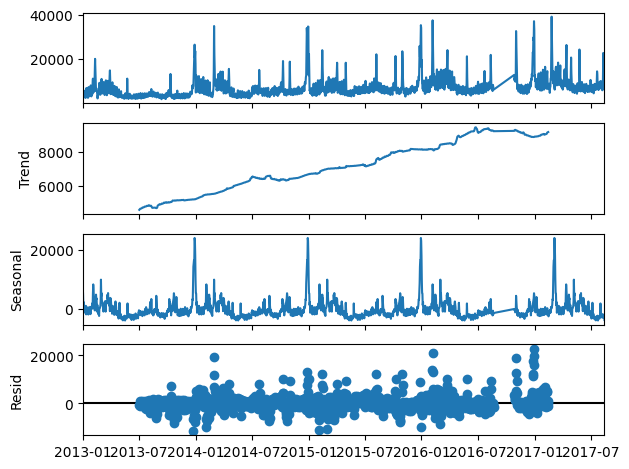

In [ ]:
decomposition = seasonal_decompose(df, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

print(f"Шумовая часть содержит {len(resid)} элементов, из них {resid.notna().sum()} числовых элемента.")
print(f"Трендовая часть содержит {len(trend)} элементов, из них {trend.notna().sum()} числовых элемента.")
print(f"Сезонная часть содержит {len(seasonal)} элементов, из них {seasonal.notna().sum()} числовых элемента.")

Шумовая часть содержит 1618 элементов, из них 1254 числовых элемента.
Трендовая часть содержит 1618 элементов, из них 1254 числовых элемента.
Сезонная часть содержит 1618 элементов, из них 1618 числовых элемента.


Рассмотрим поближе как ведут себя остатки. Выясним есть ли автокорреляция с помощью теста Дарбина-Уотсона.

<Axes: xlabel='date'>

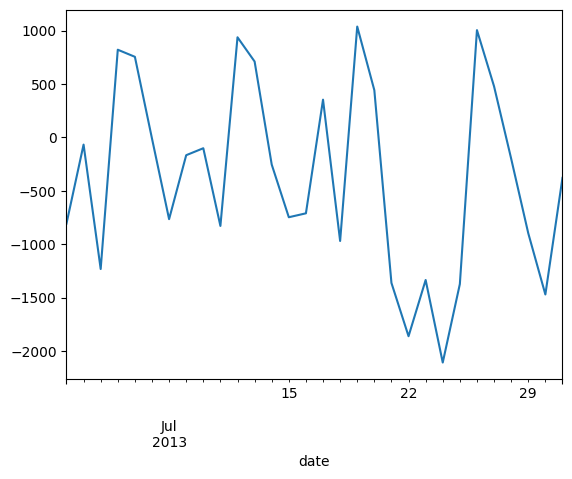

In [ ]:
resid = resid.dropna()
trend = trend.dropna()

resid[:30].plot()

In [ ]:
H0 = "Между остатками нет корреляции"
HA = "Остатки автокоррелированы"
DW = durbin_watson(resid)
if 1.5 <= DW <= 2.5:
  print(H0)
elif DW < 1.5:
  print(f"Корреляция положительна, DW = {round(DW,3)}.")
else:
  print(f"Корреляция отрицательна, DW = {round(DW,3)}.")


Корреляция положительна, DW = 0.742.


В анализируемом датафрейме 1618 наблюдений. В ряде присутствует восходящий тренд. Выражена сезонность: пики продаж на рубеже годов. Остатки ряда имеют положительную автокорреляцию, возможно кроме сезонности на показания влияют другие признаки. В торговле на скачки выручки помимо сезонности может оказывать реклама: акции "1+1", распродажи, промокоды (в том числе персональные).

Выполним тест Дики-Фуллера для проверки ряда на стационарность.

In [ ]:
test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -4.858992665318182
p-value:  4.188394192907759e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
Ряд стационарен


Разбьём временной ряд на 3 набора и выведем размеры полученных подвыборок.

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

print()
print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

Fold 0:
  Train: index=[   0    1    2 ... 1594 1595 1596]
  Test:  index=[1597 1598 1599 1600 1601 1602 1603]
Fold 1:
  Train: index=[   0    1    2 ... 1601 1602 1603]
  Test:  index=[1604 1605 1606 1607 1608 1609 1610]
Fold 2:
  Train: index=[   0    1    2 ... 1608 1609 1610]
  Test:  index=[1611 1612 1613 1614 1615 1616 1617]

TRAIN size: 1611 TEST size: 7


# 3. Расчёт факторов при помощи pandas.

Построим скользящее среднее c окном 5 и скользящее квадратическое отклонение c окном 5.

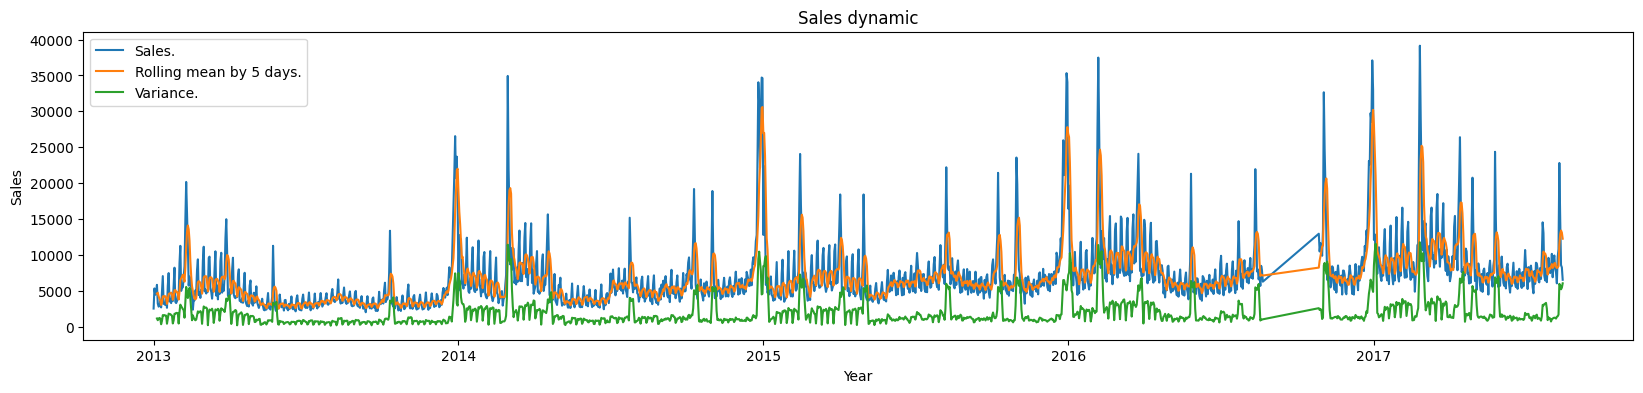

In [ ]:
df['5d_rolling_mean'] = df.unit_sales.rolling(window=5).apply(np.mean)
df['5d_variance'] = df.unit_sales.rolling(window=5).apply(np.std)

#визуализация графиков
fig = plt.figure(figsize=(20, 4))

plt.plot(df['unit_sales'], label="Sales.")
plt.plot(df['5d_rolling_mean'], label='Rolling mean by 5 days.')
plt.plot(df['5d_variance'], label='Variance.')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Построим оконное среднее с окном в 10 точек.

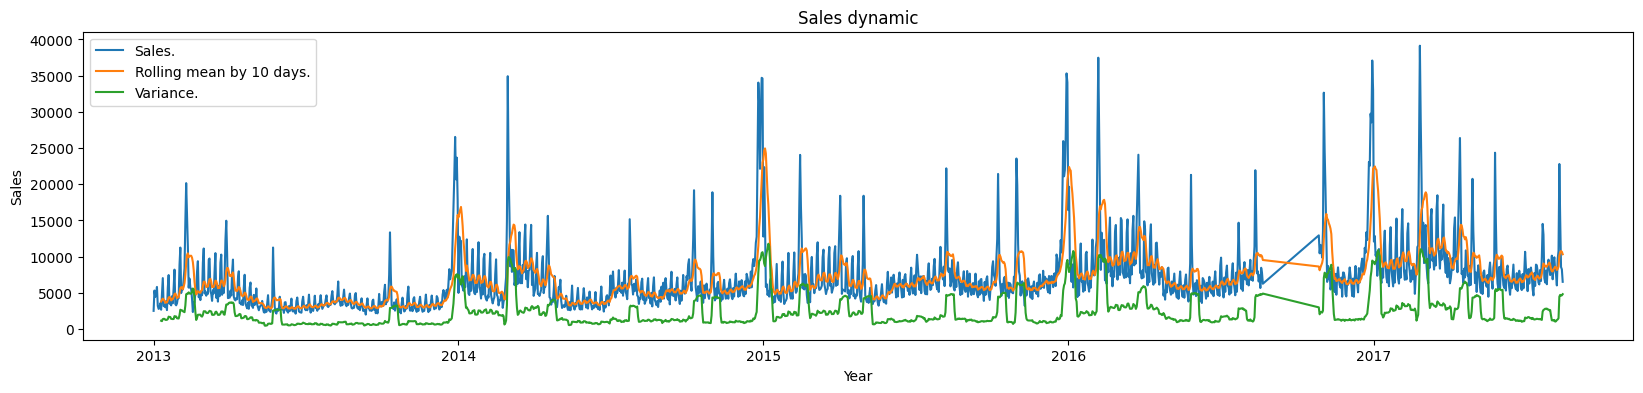

In [ ]:
df['10d_rolling_mean'] = df.unit_sales.rolling(window=10).apply(np.mean)
df['10d_variance'] = df.unit_sales.rolling(window=10).apply(np.std)

#визуализация графиков
fig = plt.figure(figsize=(20, 4))

plt.plot(df['unit_sales'], label="Sales.")
plt.plot(df['10d_rolling_mean'], label='Rolling mean by 10 days.')
plt.plot(df['10d_variance'], label='Variance.')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Построим линии Боллинджера с окном в 30.

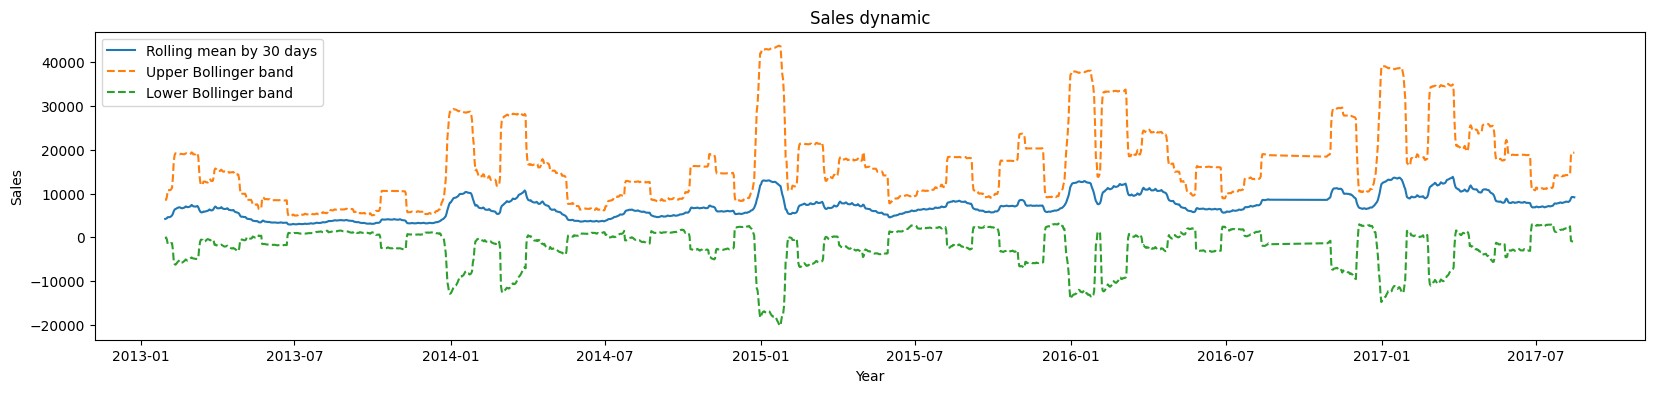

In [ ]:
df['30d_rolling_mean'] = df.unit_sales.rolling(window=30).apply(np.mean)
df['30d_variance'] = df.unit_sales.rolling(window=30).apply(np.std)

df['upper_bound'] = df['30d_rolling_mean'] + 3*abs(df['30d_variance'])
df['lower_bound'] = df['30d_rolling_mean'] - 3*abs(df['30d_variance'])


#визуализация графиков
fig = plt.figure(figsize=(20, 4))

#plt.plot(df['unit_sales'], label="Sales")
plt.plot(df['30d_rolling_mean'], label='Rolling mean by 30 days')
plt.plot(df['upper_bound'], label='Upper Bollinger band', linestyle='dashed')
plt.plot(df['lower_bound'], label='Lower Bollinger band', linestyle='dashed')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Построим экспоненциально среднее с окном в 7 точек.

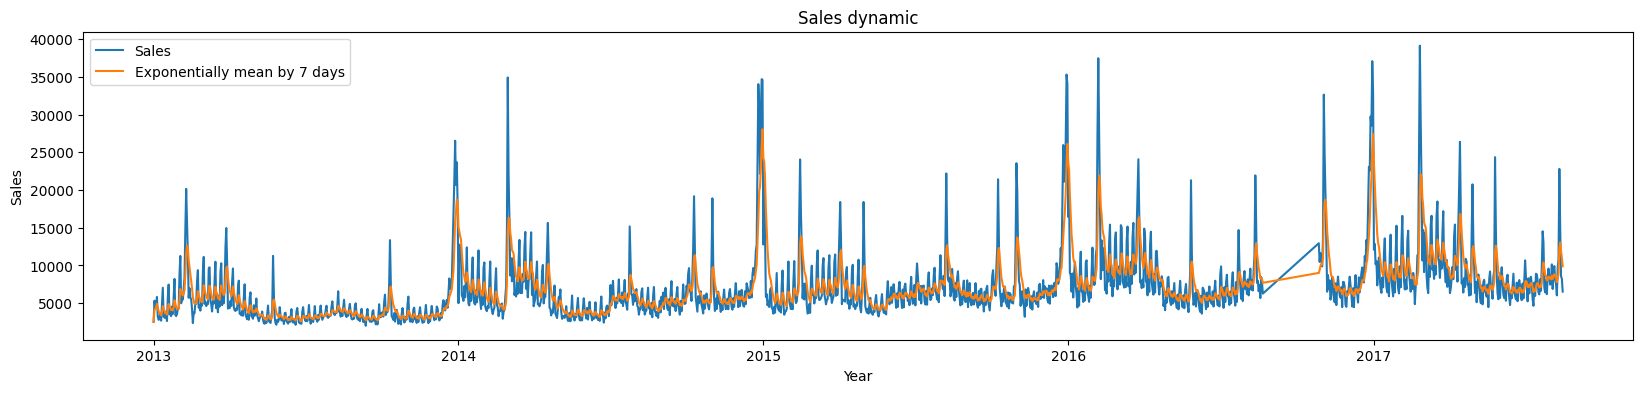

In [ ]:
df['7d_ewm'] = df.unit_sales.ewm(span=7).mean()

#визуализация графиков
fig = plt.figure(figsize=(20, 4))

plt.plot(df['unit_sales'], label="Sales")
plt.plot(df['7d_ewm'], label='Exponentially mean by 7 days')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Построим скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10).

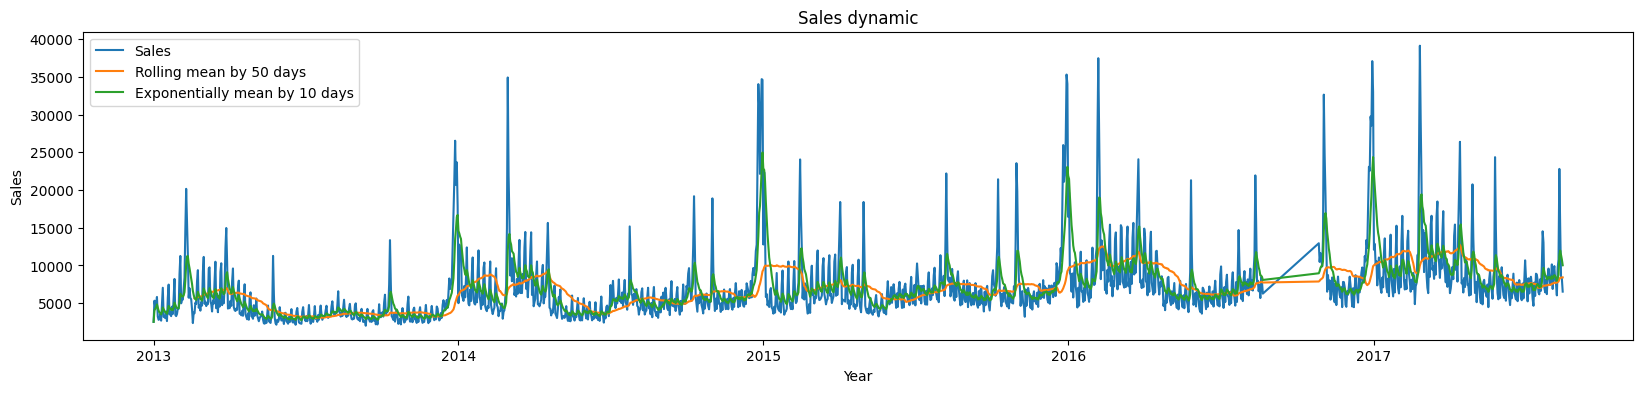

In [ ]:
df['50d_rolling_mean'] = df.unit_sales.rolling(window=50).apply(np.mean)
df['10d_ewm'] = df.unit_sales.ewm(span=10).mean()

#визуализация графиков
fig = plt.figure(figsize=(20, 4))

plt.plot(df['unit_sales'], label="Sales")
plt.plot(df['50d_rolling_mean'], label='Rolling mean by 50 days')
plt.plot(df['10d_ewm'], label='Exponentially mean by 10 days')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Напишем скользящую функцию, которая будет являться средним арифметическим между максимальным и минимальным значением unit_sales, используя окно 10.

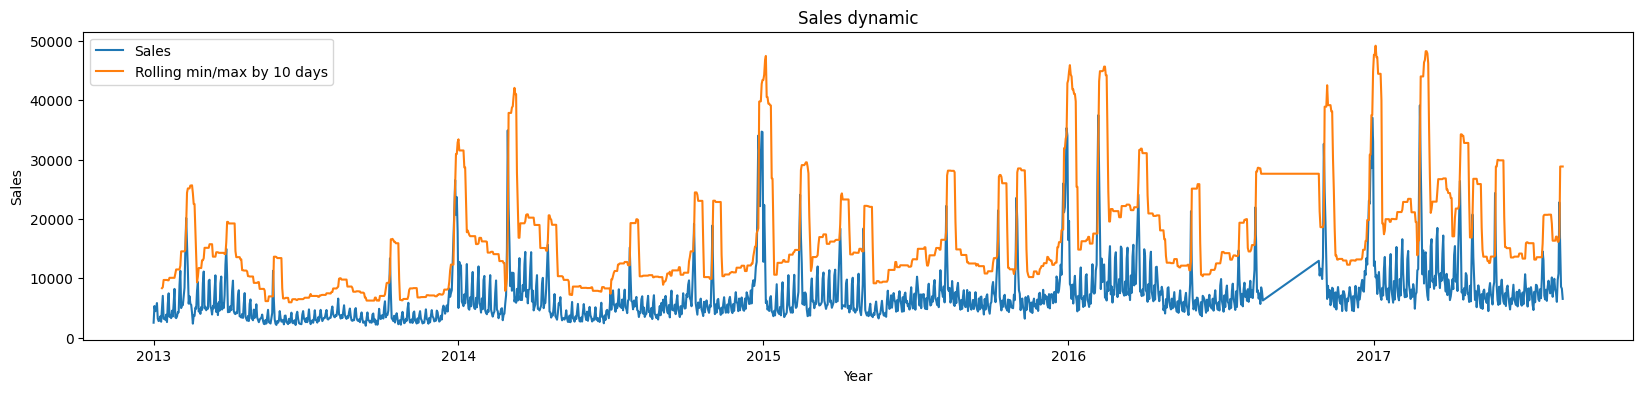

In [ ]:
def rolling_func(Series, window=10):
  Series.to_list()
  start = 0
  result = []

  for ind in range(len(Series)):
    if len(Series[start:ind]) < window:
      result.append(np.nan)
    if len(Series[start:ind]) == window:
      res = (max(Series[start:ind]) + min(Series[start:ind]))
      start += 1
      result.append(res)

  return result

df['my_func'] = rolling_func(df.unit_sales)

#визуализация графиков
fig = plt.figure(figsize=(20, 4))
plt.plot(df['unit_sales'], label="Sales")
plt.plot(df['my_func'], label='Rolling min/max by 10 days')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales dynamic', fontsize=12)
plt.legend()
plt.show()

Получим лаговые факторы с 7-го по 10-й предыдущих дня (лаг7, лаг8, лаг9, лаг10) и отобразите на графике.


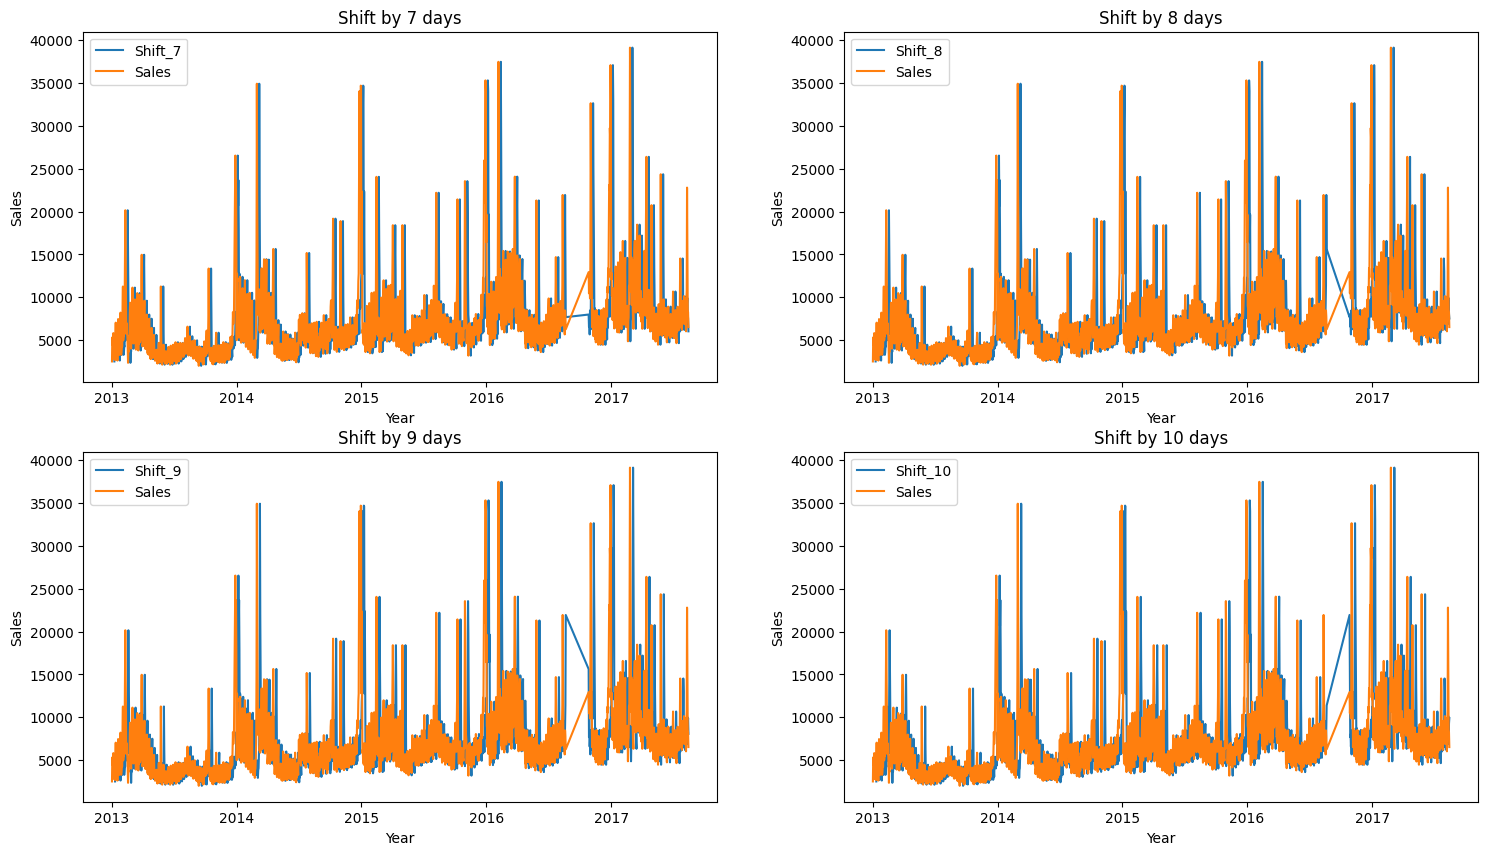

In [ ]:
df['shift_7'] = df.unit_sales.shift(7)
df['shift_8'] = df.unit_sales.shift(8)
df['shift_9'] = df.unit_sales.shift(9)
df['shift_10'] = df.unit_sales.shift(10)

#визуализация графиков
fig = plt.figure(figsize=(18, 10))

#shift_7
plt.subplot(221)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Shift by 7 days')
plt.plot(df['shift_7'], label="Shift_7")
plt.plot(df['unit_sales'], label="Sales")
plt.legend(loc='upper left')

#shift_8
plt.subplot(222)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Shift by 8 days')
plt.plot(df['shift_8'], label="Shift_8")
plt.plot(df['unit_sales'], label="Sales")
plt.legend(loc='upper left')

#shift_9
plt.subplot(223)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Shift by 9 days')
plt.plot(df['shift_9'], label="Shift_9")
plt.plot(df['unit_sales'], label="Sales")
plt.legend(loc='upper left')

#shift_10
plt.subplot(224)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Shift by 10 days')
plt.plot(df['shift_10'], label="Shift_10")
plt.plot(df['unit_sales'], label="Sales")
plt.legend(loc='upper left')

plt.show()

# 4. ARIMA/SARIMA.

Выберем продукт с номером 103501 (item_nbr) и приведем данные к виду временного ряда с группировкой по дате и агрегацией .sum()['unit_sales'].

In [ ]:
item_103501 = pd.read_csv('item_103501.csv')
#item_103501 = train[train.item_nbr==103501].groupby("date")['unit_sales'].sum().reset_index()
item_103501 = item_103501.set_index(pd.DatetimeIndex(item_103501['date']))
item_103501.drop(['date'], axis=1, inplace=True)
item_103501.head()

,unit_sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


Проведем тест Адфуллера и вясним стационарен ли ряд.

In [ ]:
test = adfuller(item_103501['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -4.154403058014621
p-value:  0.0007863083913836263
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
Ряд стационарен


Построим прогноз методом скользящего среднего с окном 6. Посчитаем метрики MSE, MAE, MAPE.

In [ ]:
def moving_average_forecast(Series, window=6):
  '''Функция расчета скользящей средней'''
  forecast = []
  for time in range(len(Series) - window):
    forecast.append(Series[time:time + window].mean())
  return np.array(forecast)

def mape_func(y_actual, y_predict):
  '''Функция расчета MAPE'''
  mape = np.mean(np.abs((y_actual - y_predict)/y_actual) * 100)
  return mape

mean_squared_error: 287.088
mean_absolute_error: 13.417
mean_absolute_percentage_error: 17.214


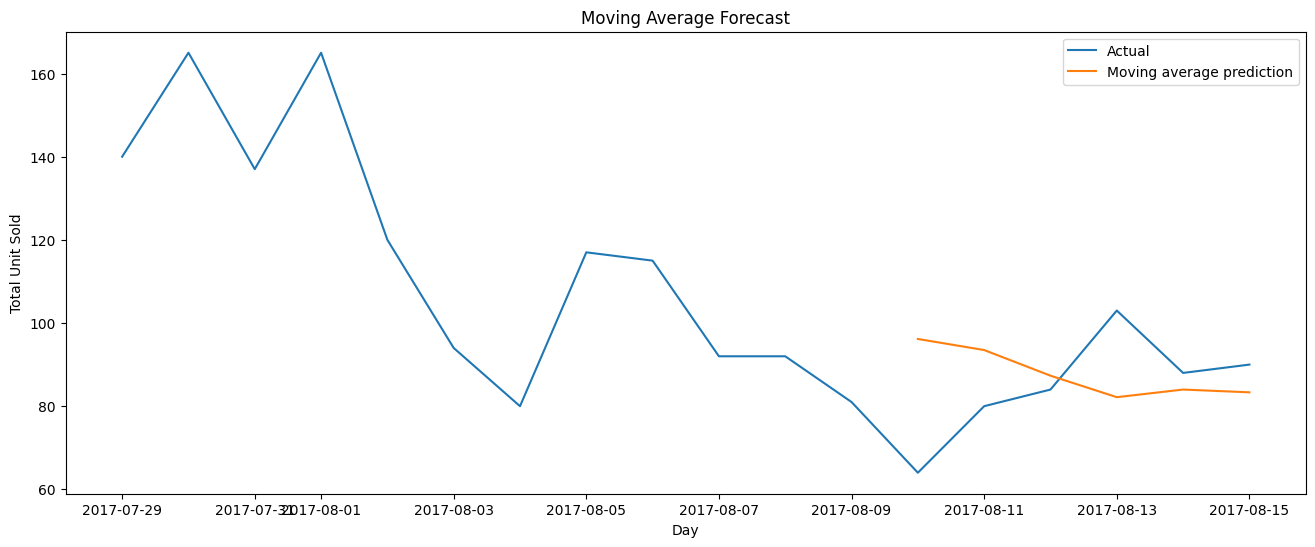

In [ ]:
MA_days = 6

shown_train_size = MA_days * 3
MA_forecast = moving_average_forecast(item_103501.unit_sales, MA_days)
MA_forecast = pd.Series(MA_forecast[-MA_days:],
                        index = item_103501.iloc[-MA_days:].index)

#print(MA_forecast[-MA_days:].shape, item_103501.unit_sales[-MA_days:].shape)

print("mean_squared_error:",   round(mean_squared_error(item_103501.unit_sales.values[-MA_days:], MA_forecast[-MA_days:]), 3))
print("mean_absolute_error:",  round(mean_absolute_error(item_103501.unit_sales.values[-MA_days:], MA_forecast[-MA_days:]), 3))
print("mean_absolute_percentage_error:", round(mape_func(item_103501.unit_sales.values[-MA_days:], MA_forecast[-MA_days:]), 3))

#визуализация графиков
plt.figure(figsize=(16,6))
plt.plot(item_103501.unit_sales[-shown_train_size:], label="Actual")
plt.plot(MA_forecast[-MA_days:], label="Moving average prediction")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")
plt.show()


Сделаем лаги с 1 по 6.

In [ ]:
data = pd.DataFrame()
data['original_values'] = item_103501.unit_sales

data['shift_1'] = data['original_values'].shift(1)
data['shift_2'] = data['original_values'].shift(2)
data['shift_3'] = data['original_values'].shift(3)
data['shift_4'] = data['original_values'].shift(4)
data['shift_5'] = data['original_values'].shift(5)
data['shift_6'] = data['original_values'].shift(6)
data.dropna(inplace=True)

Отложим 2 последних дня в тестовую выборку для совершения предсказания.

In [ ]:
predict_size = 2

X_train, y_train = data[:-predict_size].drop(['original_values'], axis =1), data[:-predict_size]['original_values']
X_test, y_test  = data[-predict_size:].drop(['original_values'], axis =1), data[-predict_size:]['original_values']

Сделаем прогноз линейной регрессией, посчитайте значения метрик MSE, MAE, MAPE.

mean_squared_error: 107.89
mean_absolute_error: 7.899
mean_absolute_percentage_error: 8.961


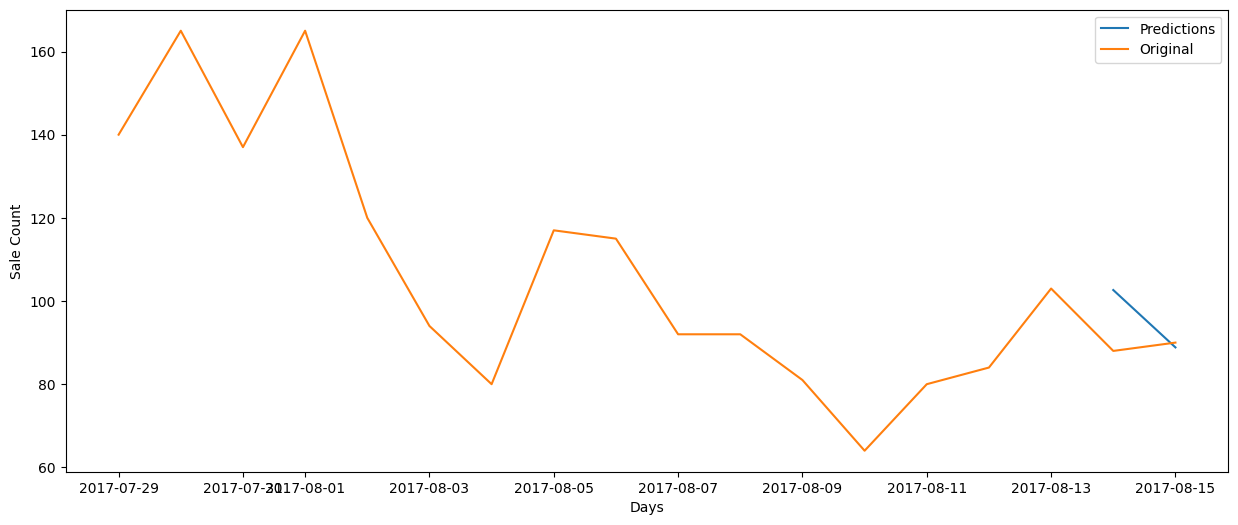

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train)

y_pred = pd.Series(lin_reg.predict(X_test), index=X_test.index)

print("mean_squared_error:",   round(mean_squared_error(y_test, y_pred), 3))
print("mean_absolute_error:",  round(mean_absolute_error(y_test, y_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, y_pred), 3))

# визуализация
plt.figure(figsize=(15,6))
plt.plot(y_pred ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")
plt.legend()
plt.show()

Определиим p и q, построим ARIMA и сравним метрики.

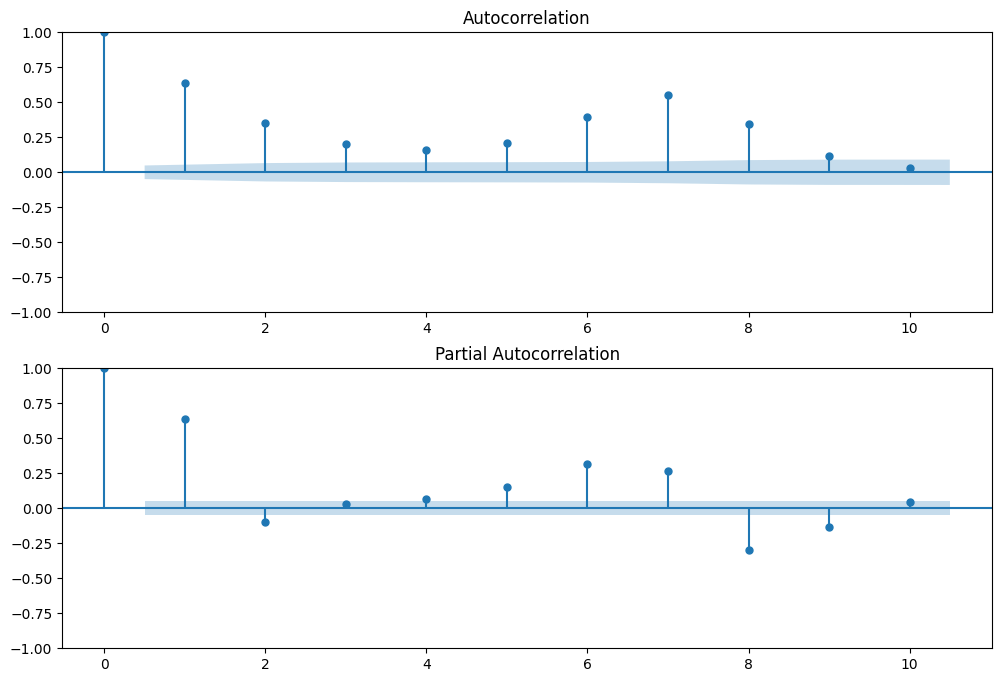

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['original_values'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['original_values'], lags=10, ax=ax2)

mean_squared_error: 1.69
mean_absolute_error: 0.983
mean_absolute_percentage_error: 1.116


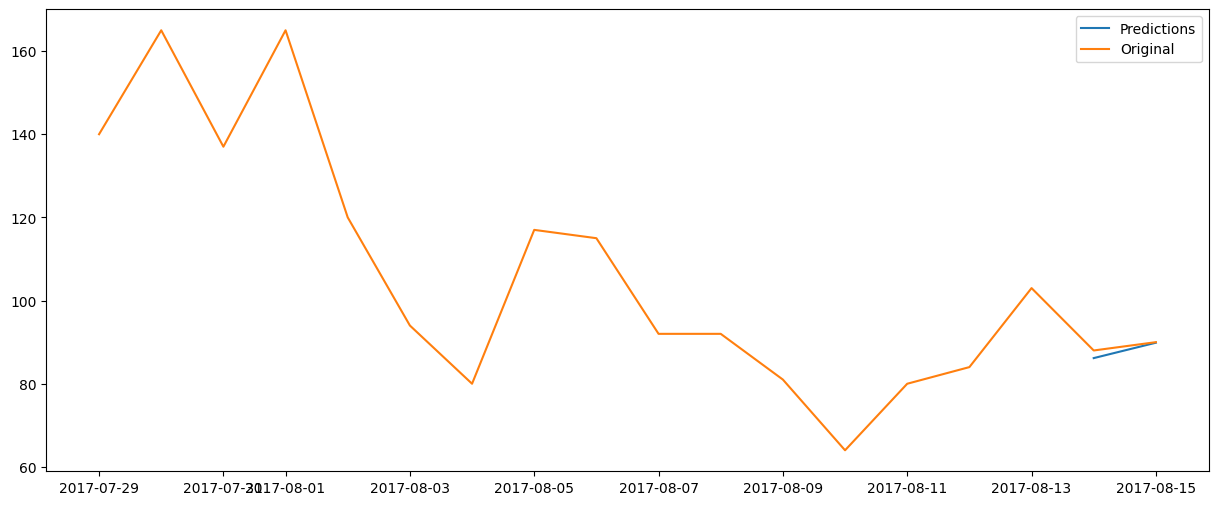

In [ ]:
p = 9
d = 0
q = 8

model = ARIMA(y_train.values.reshape(-1), order=(p, d, q))

train_size = len(y_train)   #1617
test_size = predict_size    #2
arima_pred = model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)

print("mean_squared_error:",   round(mean_squared_error(y_test, arima_pred), 3))
print("mean_absolute_error:",  round(mean_absolute_error(y_test, arima_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, arima_pred), 3))


plt.figure(figsize=(15,6))
plt.plot(pd.Series(arima_pred, index=y_test.index) ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.legend()
plt.show()

# 5. FPProphet.

Приведем данные train.csv к виду временного ряда, сгруппированного по дате, с агрегирующей функцией sum() для столбца unit_sales.

In [ ]:
#df_prophet = train.groupby('date')['unit_sales'].sum()
df_prophet = pd.read_csv('df_prophet.csv')
df_prophet.head()

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


In [ ]:
#df_prophet.to_csv('df_prophet.csv', index=False)

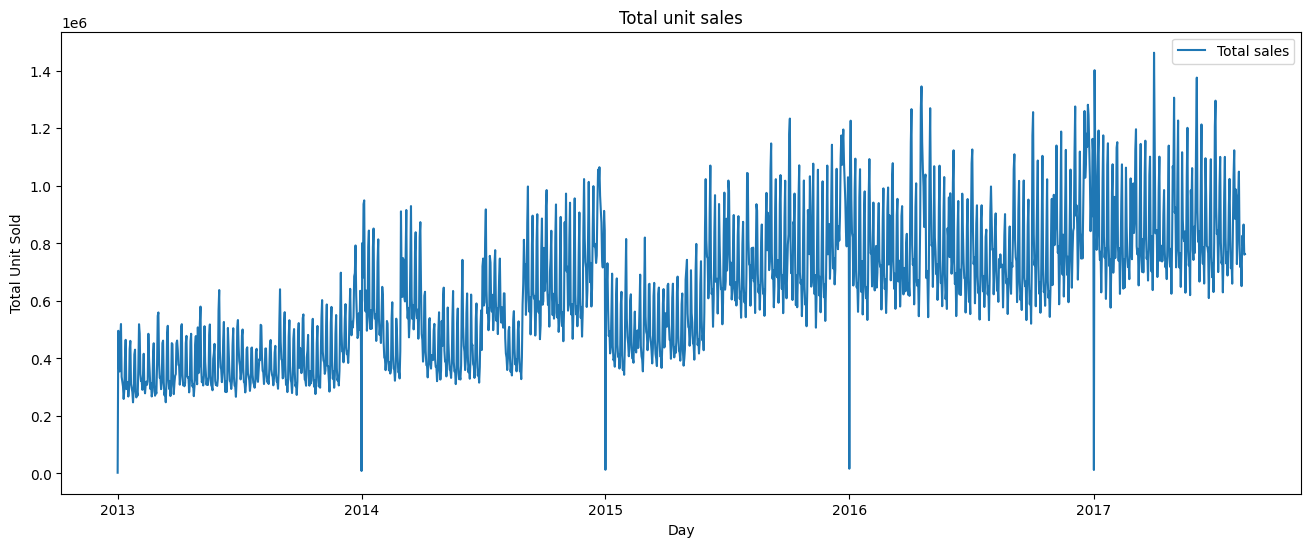

In [ ]:
#визуализация графиков
df_prophet_vis = df_prophet.copy()
df_prophet_vis = df_prophet_vis.set_index(pd.DatetimeIndex(df_prophet_vis['date']))
df_prophet_vis.drop('date', axis=1, inplace=True)

plt.figure(figsize=(16,6))
plt.plot(df_prophet_vis, label="Total sales")

plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Total unit sales")
plt.legend(loc="upper right")
plt.show()


Попробуем выполнить предсказание пророком (prophet) на год вперёд (periods=365) и отобразим на графике. Посчитаем RMSE.

In [ ]:
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


In [ ]:
periods=365
model = Prophet().fit(df_prophet)
future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)
#display(forecast.head())
print()
print("Root_mean_squared_error:",   np.sqrt(np.mean((forecast.loc[-periods:, 'yhat'] - df_prophet['y'])**2)))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/rpapxi0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/_xf9em8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27437', 'data', 'file=/tmp/tmp505labxl/rpapxi0l.json', 'init=/tmp/tmp505labxl/_xf9em8i.json', 'output', 'file=/tmp/tmp505labxl/prophet_modelpvz6kpew/prophet_model-20240807171040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Root_mean_squared_error: 108067.29689441055


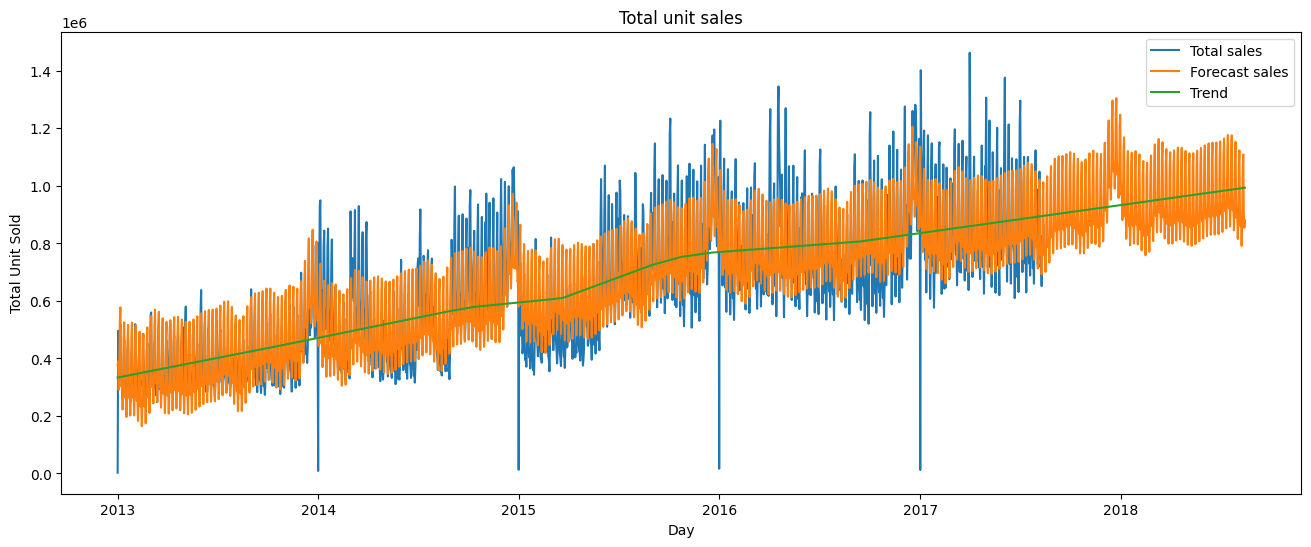

In [ ]:
#визуализация графиков
## подготовка данных
df_prophet_vis = pd.concat([df_prophet['y'], forecast[['ds','trend','yhat_lower','yhat_upper', 'yhat']]], axis=1)
df_prophet_vis.set_index(pd.DatetimeIndex(df_prophet_vis['ds']), inplace=True)
df_prophet_vis.drop(['ds'], axis=1, inplace=True)

## отрисовка графиков
plt.figure(figsize=(16,6))
plt.plot(df_prophet_vis.y, label="Total sales")
plt.plot(df_prophet_vis['yhat'], label='Forecast sales')
plt.plot(df_prophet_vis['trend'], label='Trend')
#plt.plot(df_prophet_vis['yhat_lower'], label='Lower')
#plt.plot(df_prophet_vis['yhat_upper'], label='Upper')

## настройки
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Total unit sales")
plt.legend(loc="upper right")
plt.show()

Прогноз наивен, тренд почти прямой. Уточним параметр changepoint_prior_scale = 3 и посмотрим как изменится тренд.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/dhwx3eax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/12c7u4s7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26856', 'data', 'file=/tmp/tmp505labxl/dhwx3eax.json', 'init=/tmp/tmp505labxl/12c7u4s7.json', 'output', 'file=/tmp/tmp505labxl/prophet_modelvcf9sw5i/prophet_model-20240807171042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Root_mean_squared_error: 97411.68680072486


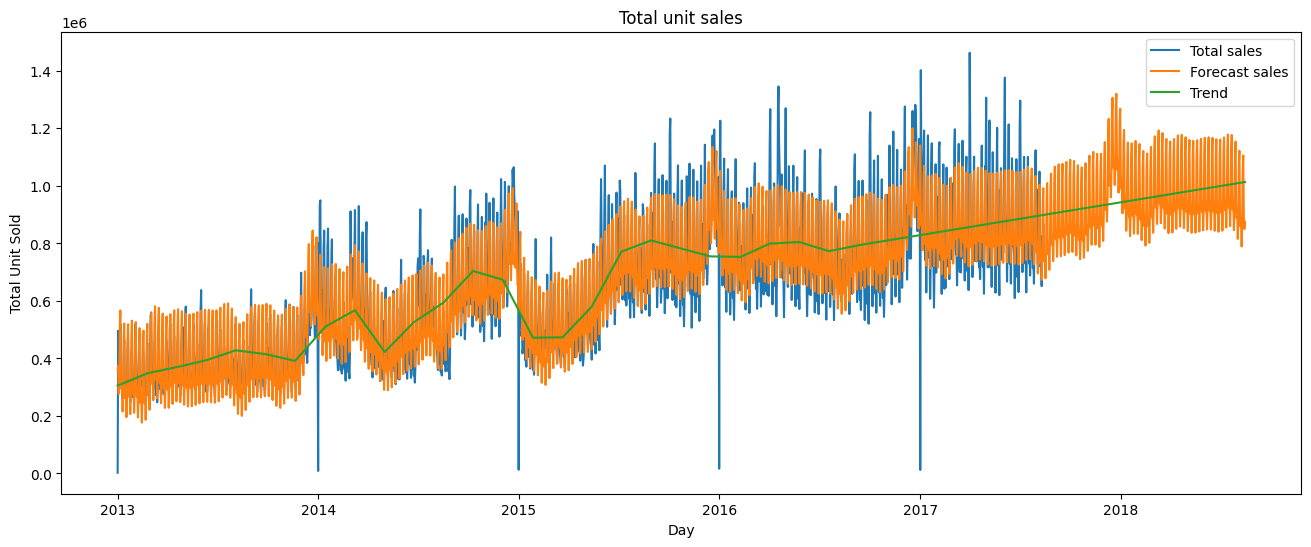

In [ ]:
model = Prophet(changepoint_prior_scale=3).fit(df_prophet)
future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)
forecast.head()
print()
print("Root_mean_squared_error:",   np.sqrt(np.mean((forecast.loc[-periods:, 'yhat'] - df_prophet['y'])**2)))


#визуализация графиков
## подготовка данных
df_prophet_vis = pd.concat([df_prophet['y'], forecast[['ds','trend','yhat_lower','yhat_upper', 'yhat']]], axis=1)
df_prophet_vis.set_index(pd.DatetimeIndex(df_prophet_vis['ds']), inplace=True)
df_prophet_vis.drop(['ds'], axis=1, inplace=True)

## отрисовка графиков
plt.figure(figsize=(16,6))
plt.plot(df_prophet_vis.y, label="Total sales")
plt.plot(df_prophet_vis['yhat'], label='Forecast sales')
plt.plot(df_prophet_vis['trend'], label='Trend')
#plt.plot(df_prophet_vis['yhat_lower'], label='Lower')
#plt.plot(df_prophet_vis['yhat_upper'], label='Upper')

## настройки
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Total unit sales")
plt.legend(loc="upper right")
plt.show()

Ошибка существенно уменьшилась. Тренд стал более похож на схематический график, который получился при декомпозиции ряда.

Добавим в модель месячную сезонность (name='monthly', period=30.5, fourier_order=5).

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/48fjaje0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/8f4lse99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93952', 'data', 'file=/tmp/tmp505labxl/48fjaje0.json', 'init=/tmp/tmp505labxl/8f4lse99.json', 'output', 'file=/tmp/tmp505labxl/prophet_model2fyd1qrp/prophet_model-20240807171044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Root_mean_squared_error: 90867.34580607513


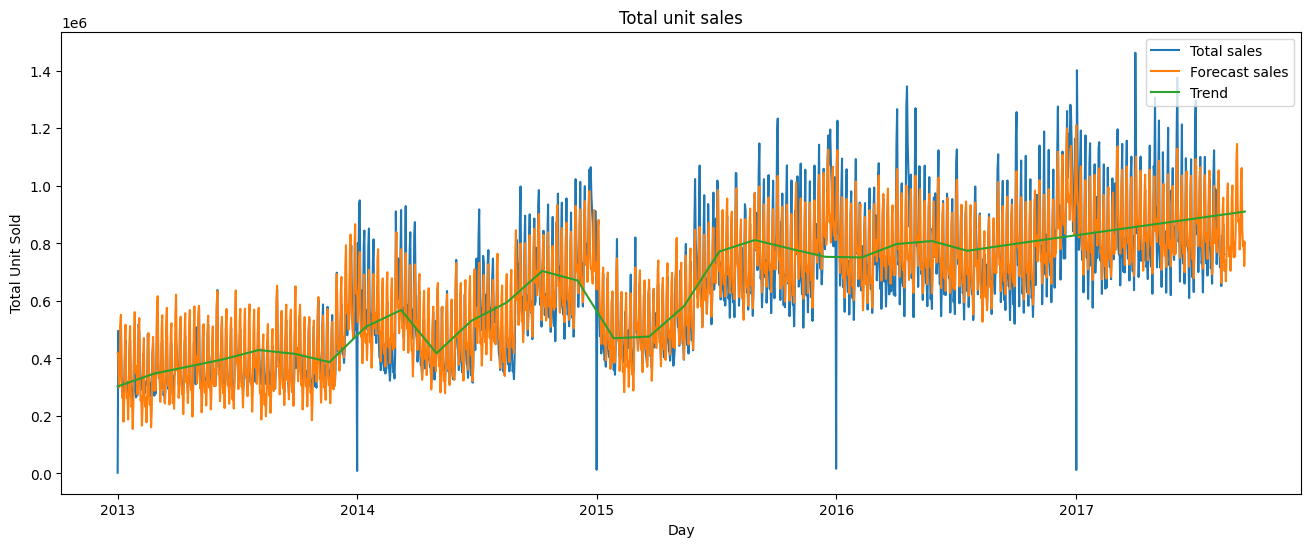

In [ ]:
model = Prophet(changepoint_prior_scale=3)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=31)
forecast = model.predict(future)
#forecast.head()
print()
print("Root_mean_squared_error:",   np.sqrt(np.mean((forecast.loc[-periods:, 'yhat'] - df_prophet['y'])**2)))

#визуализация графиков
## подготовка данных
df_prophet_vis = pd.concat([df_prophet['y'], forecast[['ds','trend','yhat_lower','yhat_upper', 'yhat']]], axis=1)
df_prophet_vis.set_index(pd.DatetimeIndex(df_prophet_vis['ds']), inplace=True)
df_prophet_vis.drop(['ds'], axis=1, inplace=True)

## отрисовка графиков
plt.figure(figsize=(16,6))
plt.plot(df_prophet_vis.y, label="Total sales")
plt.plot(df_prophet_vis['yhat'], label='Forecast sales')
plt.plot(df_prophet_vis['trend'], label='Trend')
#plt.plot(df_prophet_vis['yhat_lower'], label='Lower')
#plt.plot(df_prophet_vis['yhat_upper'], label='Upper')

## настройки
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Total unit sales")
plt.legend(loc="upper right")
plt.show()

Метрика улучшилась почти на 16%. Добавим данные о праздниках.

In [ ]:
holidays = pd.read_csv(holidays_events)
holidays = holidays[holidays.transferred == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
holidays.head()

,holiday,ds
0,Fundacion de Manta,2012-03-02
1,Provincializacion de Cotopaxi,2012-04-01
2,Fundacion de Cuenca,2012-04-12
3,Cantonizacion de Libertad,2012-04-14
4,Cantonizacion de Riobamba,2012-04-21


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/6lv3p0oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp505labxl/w8t62n_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43150', 'data', 'file=/tmp/tmp505labxl/6lv3p0oq.json', 'init=/tmp/tmp505labxl/w8t62n_q.json', 'output', 'file=/tmp/tmp505labxl/prophet_model04pt2fqh/prophet_model-20240807171046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Root_mean_squared_error: 74228.92705888223


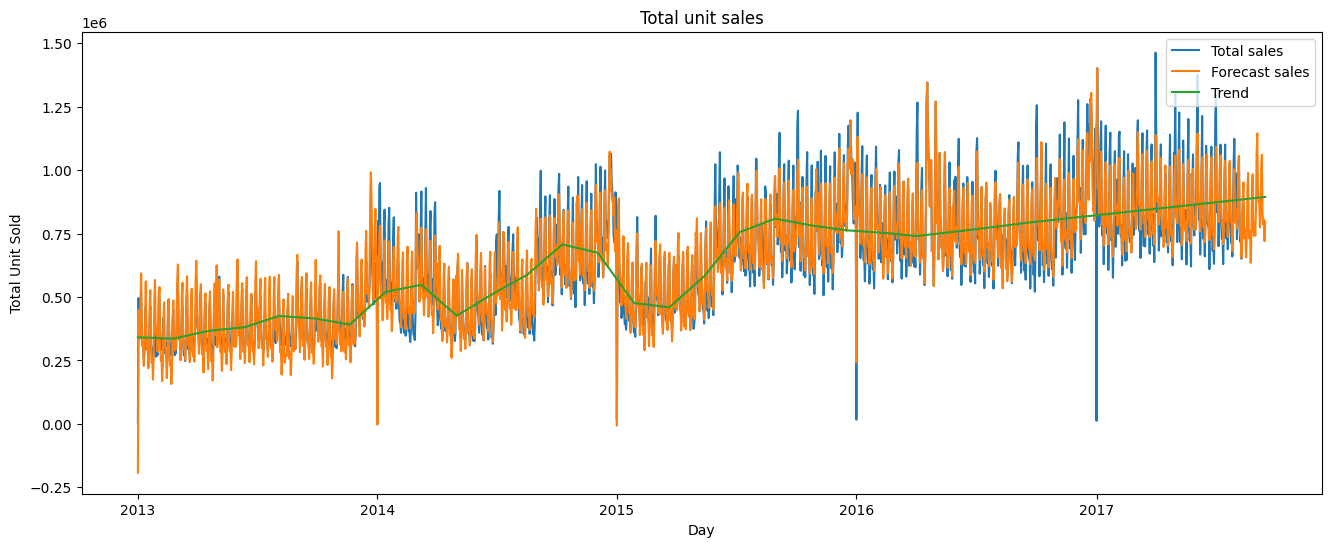

In [ ]:
model = Prophet(changepoint_prior_scale=3, holidays=holidays)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=31)
forecast = model.predict(future)
#forecast.head()
print()
print("Root_mean_squared_error:",   np.sqrt(np.mean((forecast.loc[-periods:, 'yhat'] - df_prophet['y'])**2)))

#визуализация графиков
## подготовка данных
df_prophet_vis = pd.concat([df_prophet['y'], forecast[['ds','trend','yhat_lower','yhat_upper', 'yhat']]], axis=1)
df_prophet_vis.set_index(pd.DatetimeIndex(df_prophet_vis['ds']), inplace=True)
df_prophet_vis.drop(['ds'], axis=1, inplace=True)

## отрисовка графиков
plt.figure(figsize=(16,6))
plt.plot(df_prophet_vis.y, label="Total sales")
plt.plot(df_prophet_vis['yhat'], label='Forecast sales')
plt.plot(df_prophet_vis['trend'], label='Trend')
#plt.plot(df_prophet_vis['yhat_lower'], label='Lower')
#plt.plot(df_prophet_vis['yhat_upper'], label='Upper')

## настройки
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Total unit sales")
plt.legend(loc="upper right")
plt.show()

RMSE снизилась более чем на 30% после уточнений тренд лучше прорисовался. Ошибка большая, т.к. горизон планирования достаточно большой - год.

#6. Бустинги/деревья.

### XGBoost.

Разобьем данные на train и test.

In [ ]:
df_boosting = df_prophet.copy()

df_boosting['date'] = pd.to_datetime(df_boosting['ds'])
df_boosting.drop(['ds'], axis=1, inplace=True)

train = df_boosting.iloc[:-periods].copy()     # periods=365
test = df_boosting[-periods:].copy()


Создадим временные признаки от datetime.

In [ ]:
def create_features(df, label=None):
    """создаем признаки из datetime индекса"""

    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df = df.set_index(pd.DatetimeIndex(df['date']))

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df['y']
        return X, y
    return X

X_train, y_train = create_features(train, label='date')
X_test, y_test = create_features(test, label='date')


Инициализируем и обучим модель XGBoost.

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

y_pred = xgb_model.predict(X_test)


print("mean_squared_error:",   round(mean_squared_error(y_test, y_pred), 3))
print("RMSE:",   round(np.sqrt(mean_squared_error(y_test, y_pred)), 3) )
print("mean_absolute_error:",  round(mean_absolute_error(y_test, y_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, y_pred), 3))

mean_squared_error: 18315603402.874
RMSE: 135335.152
mean_absolute_error: 96900.299
mean_absolute_percentage_error: 33.678


Отобразим на графике предсказание.

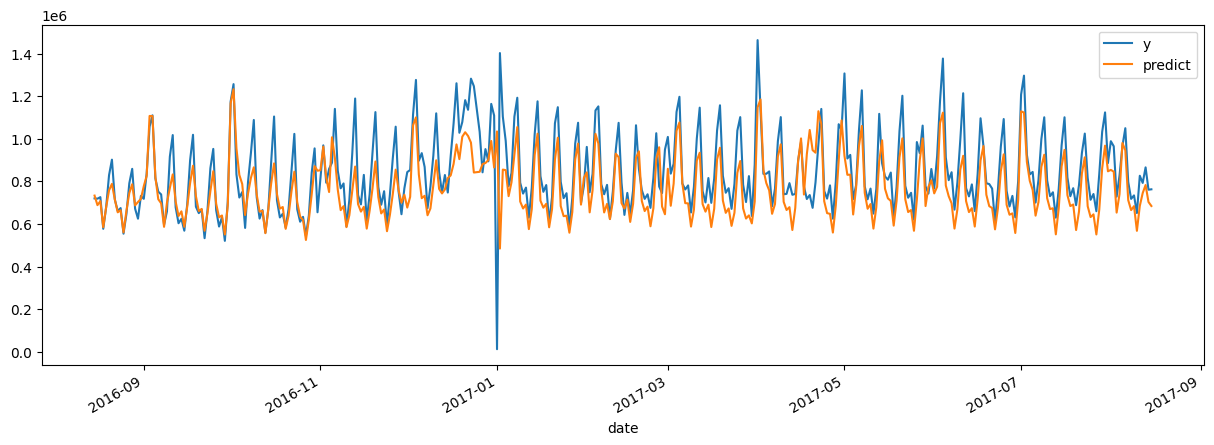

In [ ]:
df_for_visual = pd.DataFrame({'y': y_test,
                              'predict': y_pred})
_ = df_for_visual.plot(figsize=(15, 5))


Предсказание оказалось более пессимистично, чем реальные значения. Изучим какие признаки внесли наибольший вклад в модель.

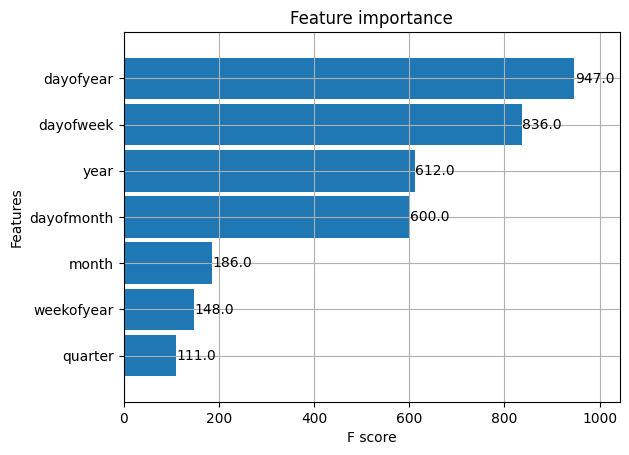

In [ ]:
_ = plot_importance(xgb_model, height=0.9)

Обогатим модель данными о праздниках.

In [ ]:
holidays = pd.read_csv(holidays_events)
holidays = holidays[holidays.transferred == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']

mean_squared_error: 16687982242.555
RMSE: 129181.973
mean_absolute_error: 95234.451
mean_absolute_percentage_error: 31.851


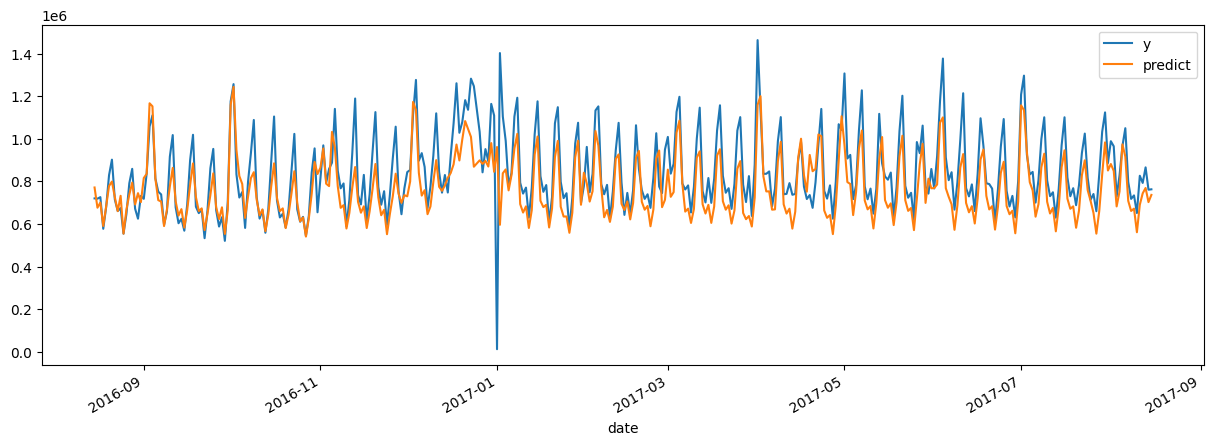

In [ ]:
df_with_holidays = df_boosting.copy()


holidays['ds'] = pd.to_datetime(holidays['ds'])
holidays_lst = list(holidays['ds'].unique())

add_holidays = df_with_holidays['date'].apply(lambda x: 1 if x in holidays_lst
                                                              else 0)

X, y = create_features(df_with_holidays, label='date')
X['holidays'] = add_holidays.values


X_train = X.iloc[:-periods]
y_train = y.iloc[:-periods]
X_test =  X.iloc[-periods:]
y_test =  y.iloc[-periods:]

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

y_pred = xgb_model.predict(X_test)
print("mean_squared_error:",   round(mean_squared_error(y_test, y_pred), 3))
print("RMSE:",   round(np.sqrt(mean_squared_error(y_test, y_pred)), 3) )
print("mean_absolute_error:",  round(mean_absolute_error(y_test, y_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, y_pred), 3))

# Отрисовка графика предсказания
df_for_visual = pd.DataFrame({'y': y_test,
                              'predict': y_pred})
_ = df_for_visual.plot(figsize=(15, 5))


Оценим вклад признаков в работу модели.

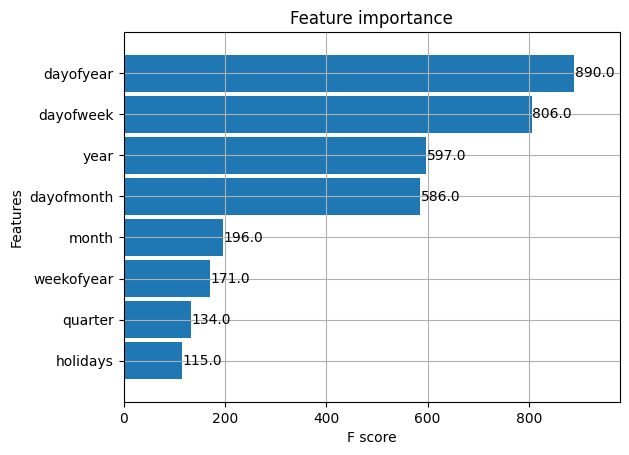

In [ ]:
_ = plot_importance(xgb_model, height=0.9)

Данные о праздниках существенного вклада не внесли, но метрика MAPE снизилась почти на 2%.

### CatBoost.

Проведём те же манипуляции с CatBoost. Для начала обучим и посчитаем метрики без данных о праздниках.

mean_squared_error: 21498168904.562
RMSE: 146622.539
mean_absolute_error: 107459.768
mean_absolute_percentage_error: 30.649


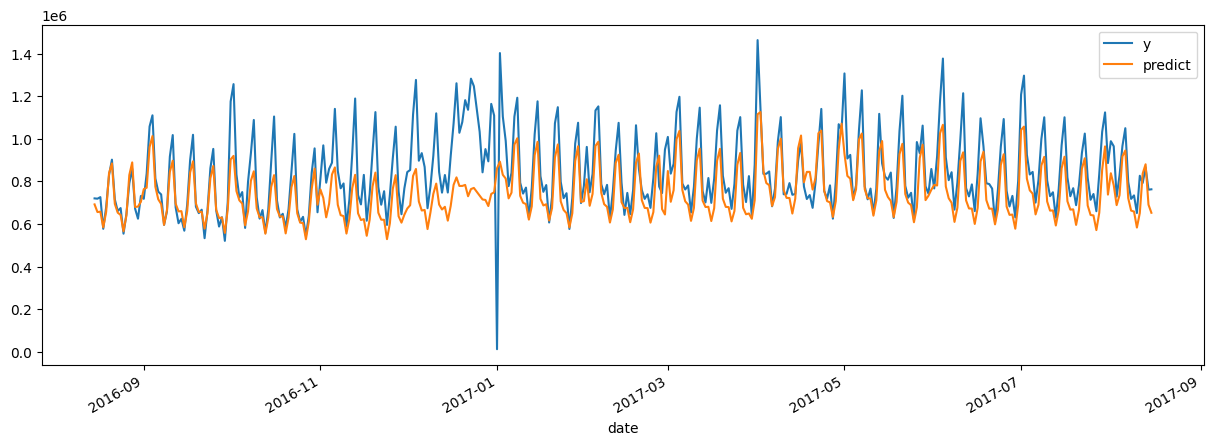

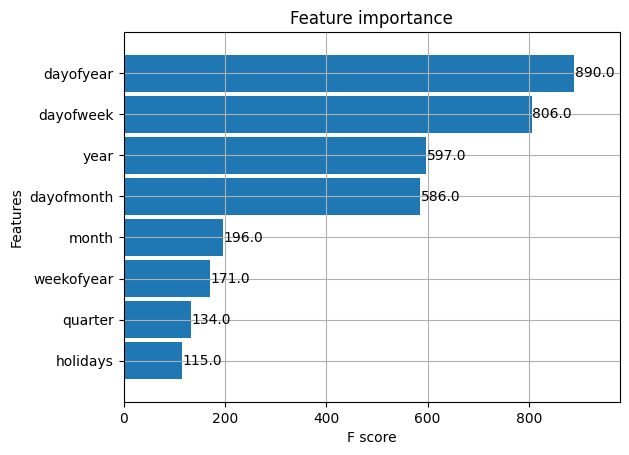

In [ ]:
# Подготовка данных
train = df_boosting.iloc[:-periods].copy()     # periods=365
test = df_boosting[-periods:].copy()

X_train, y_train = create_features(train, label='date')
X_test, y_test = create_features(test, label='date')

# Инициализация и обучение модели
cbr_model = CatBoostRegressor(n_estimators=1000)
cbr_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

# Предсказание и расчет метрик
y_pred = cbr_model.predict(X_test)
print("mean_squared_error:",   round(mean_squared_error(y_test, y_pred), 3))
print("RMSE:",   round(np.sqrt(mean_squared_error(y_test, y_pred)), 3) )
print("mean_absolute_error:",  round(mean_absolute_error(y_test, y_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, y_pred), 3))

# Отрисовка графика предсказания
df_for_visual = pd.DataFrame({'y': y_test,
                              'predict': y_pred})
_ = df_for_visual.plot(figsize=(15, 5))

# Вклад признаков в модель
_ = plot_importance(xgb_model, height=0.9)

Тренд уже существенно отличается, особенно в месяцы перед 01.01.2018г. Обогатим обучающую модель данными о праздниках.

mean_squared_error: 21817931425.817
RMSE: 147708.942
mean_absolute_error: 108403.44
mean_absolute_percentage_error: 33.372


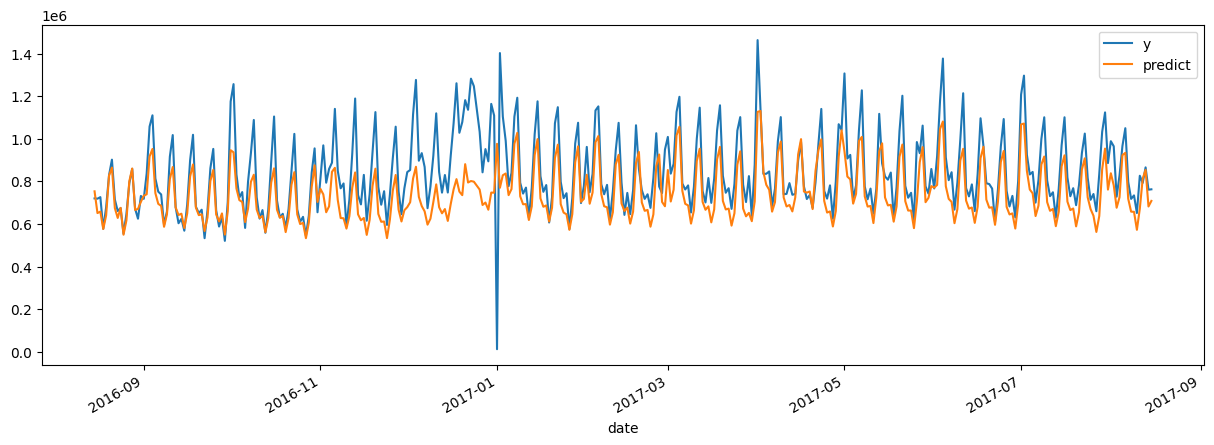

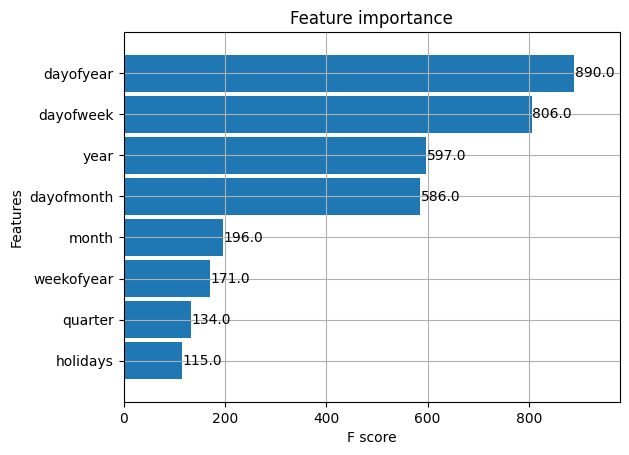

In [ ]:
# Подготовка данных
df_with_holidays = df_boosting.copy()

add_holidays = df_with_holidays['date'].apply(lambda x: 1 if x in holidays_lst
                                                              else 0)

X, y = create_features(df_with_holidays, label='date')
X['holidays'] = add_holidays.values


X_train = X.iloc[:-periods]
y_train = y.iloc[:-periods]
X_test =  X.iloc[-periods:]
y_test =  y.iloc[-periods:]

# Инициализация и обучение модели
cbr_model = CatBoostRegressor(n_estimators=1000)
cbr_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

# Предсказание и расчет метрик
y_pred = cbr_model.predict(X_test)
print("mean_squared_error:",   round(mean_squared_error(y_test, y_pred), 3))
print("RMSE:",   round(np.sqrt(mean_squared_error(y_test, y_pred)), 3) )
print("mean_absolute_error:",  round(mean_absolute_error(y_test, y_pred), 3))
print("mean_absolute_percentage_error:", round(mape_func(y_test, y_pred), 3))

# Отрисовка графика предсказания
df_for_visual = pd.DataFrame({'y': y_test,
                              'predict': y_pred})
_ = df_for_visual.plot(figsize=(15, 5))

# Вклад признаков в модель
_ = plot_importance(xgb_model, height=0.9)

Данные о праздниках увеличили ошибку модели CatBoost, в то время как ошибка XGBoost уменьшилась. В общем и целом обе модели ошибаются на 30-35%.